In [1]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import sys
import json
import time
import random

import librosa
import librosa.display
import matplotlib.pyplot as plt

import h5py
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import scipy.signal
from scipy.io import wavfile as wavf
from torch.utils.data import DataLoader, Dataset

from captum.attr import LRP
from captum.attr._utils.lrp_rules import Alpha1_Beta0_Rule, EpsilonRule

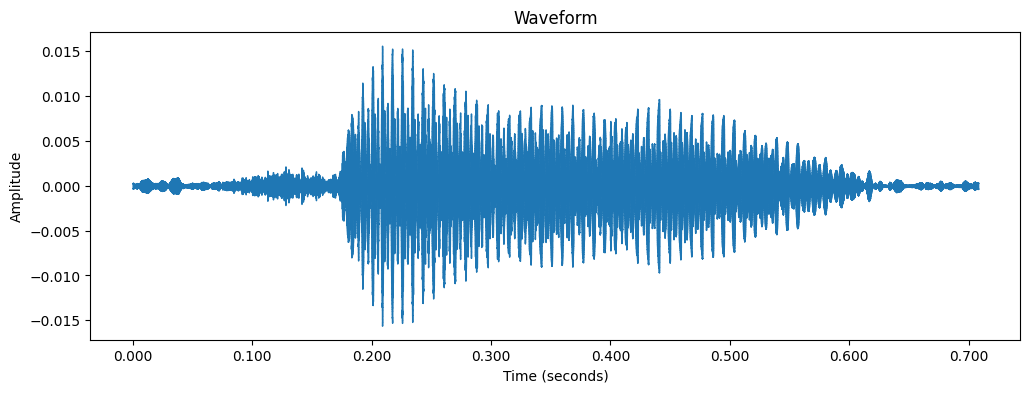

In [3]:
# Load an audio file
audio_path = '/kaggle/input/audio-mnist/data/10/0_10_35.wav'  # Replace this with the path to your audio file
audio, sr = librosa.load(audio_path)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

In [4]:
metaData = json.load(open("/kaggle/input/audio-mnist/data/audioMNIST_meta.txt"))

In [5]:
# accents = set([details["accent"] for details in metaData.values()])

# print(accents)

In [6]:
accents_map = {
    'Brasilian': 0, 
    'German/Spanish': 1, 
    'Danish': 2, 
    'South African': 3, 
    'English':4, 
    'german':5, 
    'Levant':6, 
    'South Korean':7, 
    'French':8, 
    'Spanish':9, 
    'Italian':10, 
    'Arabic':11, 
    'Tamil':12, 
    'Madras':12, 
    'Egyptian_American?':13, 
    'German':5, 
    'Chinese':14
}

In [7]:
# data_dir = "/kaggle/input/audio-mnist/data"
# target_sr = 8000  # Target sampling rate
# n_samples = 8000  # Number of samples to ensure in the audio signal
# split_ratios = (0.8, 0.1, 0.1)  # Train, validation, test split ratios
# total_files = 30000  # Total number of files
# processed_files = 0  # Counter for processed files

# # Initialize HDF5 file
# hdf5_path = 'audioNet_data.hdf5'
# with h5py.File(hdf5_path, 'w') as hdf5_file:
#     # Create groups for train, validation, and test
#     train_group = hdf5_file.create_group('train')
#     val_group = hdf5_file.create_group('validation')
#     test_group = hdf5_file.create_group('test')
#     # Iterate over folders and files
#     for speaker_folder in sorted(os.listdir(data_dir)):
#         speaker_path = os.path.join(data_dir, speaker_folder)
#         print("FolderPath - " + speaker_path)
#         if os.path.isdir(speaker_path):
            
#             if (int(speaker_folder) <= 40):
#                 target_group = train_group
#             elif (int(speaker_folder) <= 50):
#                 target_group = val_group
#             else:
#                 target_group = test_group
                
#             start_time = time.time()  # Start timer for the current folder
#             for filename in os.listdir(speaker_path):
#                 filepath = os.path.join(speaker_path, filename)
                
#                 # Extract meta information
#                 digit, person_number, repetition = filepath.rstrip(".wav").split("/")[-1].split("_")
                
#                 # Read data
#                 sample_rate, data = wavf.read(filepath)
                
#                 # Resample
#                 data = librosa.core.resample(y=data.astype(np.float32), orig_sr=sample_rate, target_sr=target_sr, res_type="scipy")
                
#                 # Padding
#                 if len(data) > n_samples:
#                     raise ValueError("Data length cannot exceed padding length.")
#                 elif len(data) < n_samples:
#                     embedded_data = np.zeros(n_samples)
#                     offset = np.random.randint(low=0, high=n_samples - len(data))
#                     embedded_data[offset:offset+len(data)] = data
#                 else:
#                     embedded_data = data
                
#                 embedded_data /= (np.percentile(embedded_data, 95) + 0.001)
                
#                 # Create dataset
#                 dataset_name = f"{digit}_{person_number}_{repetition}"
#                 target_group.create_dataset(dataset_name, data=embedded_data, compression="gzip")
#                 target_group[dataset_name].attrs['label'] = np.array([[int(digit), 0 if metaData[person_number]["gender"] == "male" else 1,accents_map[metaData[person_number]["accent"]]]])
                
#                 processed_files += 1
                
#             # Print the percentage completion
#             percentage_complete = (processed_files / total_files) * 100
#             print(f"Processed {processed_files}/{total_files} files ({percentage_complete:.2f}% complete)")
#             end_time = time.time()  # End timer for the current folder
#             print(f"Time taken: {end_time - start_time:.2f} seconds.")

# print("Processing complete. Data stored in HDF5 format.")

In [10]:
# data_dir = "/kaggle/input/audio-mnist/data"
# target_sr = 8000  # Target sampling rate
# n_samples = 8000  # Number of samples to ensure in the audio signal
# split_ratios = (0.8, 0.1, 0.1)  # Train, validation, test split ratios
# total_files = 30000  # Total number of files
# processed_files = 0  # Counter for processed files

# # Initialize HDF5 file
# hdf5_path = 'audioNet_data_accent.hdf5'

# with h5py.File(hdf5_path, 'w') as hdf5_file:
#     # Create groups for train, validation, and test
#     train_group = hdf5_file.create_group('train')
#     val_group = hdf5_file.create_group('validation')
#     test_group = hdf5_file.create_group('test')
#     # Iterate over folders and files
#     for speaker_folder in sorted(os.listdir(data_dir)):
#         speaker_path = os.path.join(data_dir, speaker_folder)
#         print("FolderPath - " + speaker_path)
#         if os.path.isdir(speaker_path):
                
#             start_time = time.time()  # Start timer for the current folder
#             for filename in os.listdir(speaker_path):
#                 filepath = os.path.join(speaker_path, filename)
                
#                 # Extract meta information
#                 digit, person_number, repetition = filepath.rstrip(".wav").split("/")[-1].split("_")
                
#                 # Read data
#                 sample_rate, data = wavf.read(filepath)
                
#                 # Resample
#                 data = librosa.core.resample(y=data.astype(np.float32), orig_sr=sample_rate, target_sr=target_sr, res_type="scipy")
                
#                 # Padding
#                 if len(data) > n_samples:
#                     raise ValueError("Data length cannot exceed padding length.")
#                 elif len(data) < n_samples:
#                     embedded_data = np.zeros(n_samples)
#                     offset = np.random.randint(low=0, high=n_samples - len(data))
#                     embedded_data[offset:offset+len(data)] = data
#                 else:
#                     embedded_data = data
                
#                 embedded_data /= (np.percentile(embedded_data, 95) + 0.001)
                
                
#                 if (int(digit) <= 7):
#                     target_group = train_group
#                 elif (int(digit) <= 8):
#                     target_group = val_group
#                 else:
#                     target_group = test_group
                
#                 # Create dataset
#                 dataset_name = f"{digit}_{person_number}_{repetition}"
#                 target_group.create_dataset(dataset_name, data=embedded_data, compression="gzip")
#                 target_group[dataset_name].attrs['label'] = np.array([[int(digit), 0 if metaData[person_number]["gender"] == "male" else 1,accents_map[metaData[person_number]["accent"]]]])
                
#                 processed_files += 1
                
#             # Print the percentage completion
#             percentage_complete = (processed_files / total_files) * 100
#             print(f"Processed {processed_files}/{total_files} files ({percentage_complete:.2f}% complete)")
#             end_time = time.time()  # End timer for the current folder
#             print(f"Time taken: {end_time - start_time:.2f} seconds.")

# print("Processing complete. Data stored in HDF5 format.")

In [9]:
import shutil
src_path = r"/kaggle/input/audiomnist/audioNet_data.hdf5"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)
print('Copied')

Copied


In [10]:
class AudioNet(nn.Module):
    def __init__(self, num_classes=10):  
        super(AudioNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 100, kernel_size=1, padding=1)
        self.conv2 = nn.Conv1d(100, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        
        # Pooling layers
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool6 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc7 = nn.Linear(128 * 125, 1024)  # Adjust the input features to match your flattened pool6 layer size
        self.fc8 = nn.Linear(1024, 512)
        self.fc9 = nn.Linear(512, num_classes)
        
        # Dropout
        self.drop7 = nn.Dropout(0.5)
        self.drop8 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = F.relu(self.conv5(x))
        x = self.pool5(x)
        x = F.relu(self.conv6(x))
        x = self.pool6(x)
        
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        
        x = self.drop7(F.relu(self.fc7(x)))
        x = self.drop8(F.relu(self.fc8(x)))
        x = self.fc9(x)
        
        return x


In [11]:
class AudioMNISTDataset(Dataset):
    def __init__(self, hdf5_path, split='train'):
        self.hdf5_path = hdf5_path
        self.split = split
        with h5py.File(self.hdf5_path, 'r') as f:
            self.keys = list(f[split].keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_path, 'r') as f:
            group = f[self.split]
            dataset = group[self.keys[idx]]
            spectrogram = np.array(dataset)
            label = dataset.attrs['label'][0,1]  # 0: digit, 1: sex, 2: accent
        spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
        return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [14]:
# Prepare Datasets and Loaders
hdf5_path = '/kaggle/working/audioNet_data.hdf5' 

train_dataset = AudioMNISTDataset(hdf5_path, 'train')
val_dataset = AudioMNISTDataset(hdf5_path, 'validation')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_epochs = 20
num_classes = 10

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define your AudioNet model here
model = AudioNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    if val_accuracy >= 99.5:
        break

Using device: cuda


100%|██████████| 625/625 [00:43<00:00, 14.21it/s]


Epoch 1, Loss: 0.1402, Val Accuracy: 98.24%


100%|██████████| 625/625 [00:43<00:00, 14.21it/s]


Epoch 2, Loss: 0.0091, Val Accuracy: 97.34%


100%|██████████| 625/625 [00:44<00:00, 14.20it/s]


Epoch 3, Loss: 0.0061, Val Accuracy: 97.00%


100%|██████████| 625/625 [00:43<00:00, 14.25it/s]


Epoch 4, Loss: 0.0060, Val Accuracy: 99.36%


100%|██████████| 625/625 [00:43<00:00, 14.25it/s]


Epoch 5, Loss: 0.0039, Val Accuracy: 99.42%


100%|██████████| 625/625 [00:44<00:00, 14.20it/s]


Epoch 6, Loss: 0.0028, Val Accuracy: 99.78%


In [15]:
# torch.save(model.state_dict(),"/kaggle/working/accentAudioNet.pt")

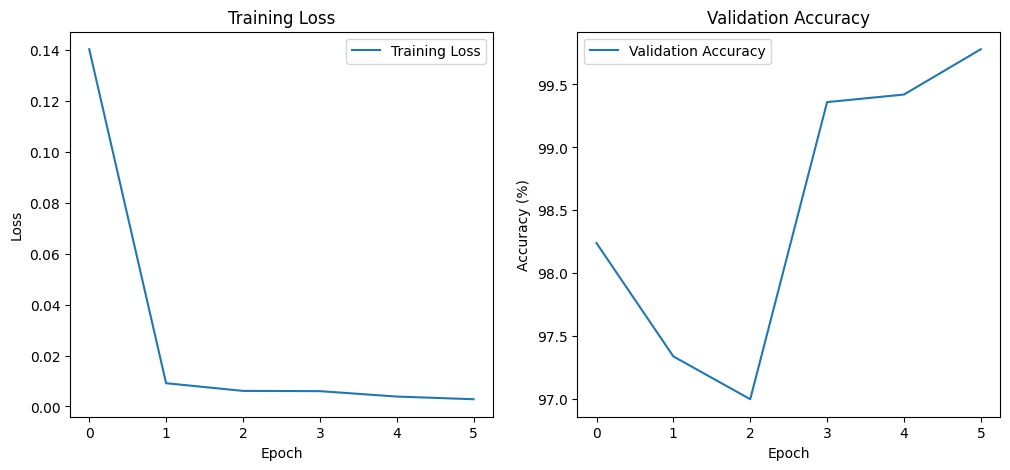

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [16]:
test_dataset = AudioMNISTDataset(hdf5_path, 'test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
    
# lrp = LRP(model)

correct = 0
total = 0
test_results = [] 
relevance_scores = []
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        
        total += target.size(0)
        correct += (predicted == target).sum().item()

        test_results.extend(predicted.cpu().numpy())
        
#         for layer in model.children():
#             setattr(layer, "rule", Alpha1_Beta0_Rule())
        
#         relevance = lrp.attribute(data, target=target)
#         relevance_scores.extend(relevance.cpu().numpy())
        
test_accuracy = 100 * correct / total
test_accuracy

100%|██████████| 157/157 [00:08<00:00, 19.01it/s]


90.32

In [43]:
def perturb_input(input_data, relevance_scores, strategy, fraction):
    """
    Perturb the input data based on the given strategy and fraction of samples to perturb.
    
    :param input_data: Original input data.
    :param relevance_scores: Relevance scores for each sample in input_data.
    :param strategy: Strategy for selecting samples to perturb ('random', 'amplitude', 'relevance').
    :param fraction: Fraction of samples to perturb.
    :return: Perturbed input data.
    """
    perturbed_data = input_data.clone()
    num_samples_to_perturb = int(fraction * input_data.numel() / input_data.shape[0])
    
    if strategy == 'random':
        for i in range(input_data.shape[0]):
            indices = torch.randperm(input_data[i].numel())[:num_samples_to_perturb]
            perturbed_data[i].view(-1)[indices] = 0
    elif strategy == 'amplitude':
        for i in range(input_data.shape[0]):
            _, indices = input_data[i].view(-1).abs().topk(num_samples_to_perturb)
            perturbed_data[i].view(-1)[indices] = 0
    elif strategy == 'relevance':
        for i in range(input_data.shape[0]):
            _, indices = relevance_scores[i].view(-1).topk(num_samples_to_perturb)
            perturbed_data[i].view(-1)[indices] = 0
    return perturbed_data

def evaluate_model_with_perturbation(test_loader, model, strategy, fraction):
    """
    Evaluate the model on the test set with input perturbation.
    
    :param test_loader: DataLoader for the test set.
    :param model: The trained model.
    :param strategy: Strategy for selecting samples to perturb.
    :param fraction: Fraction of samples to perturb.
    :return: Accuracy of the model on the perturbed test set.
    """
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Calculate relevance scores for relevance-based perturbation
            if strategy == 'relevance':
                lrp = LRP(model)
                for layer in model.children():
                    setattr(layer, "rule", EpsilonRule())
                relevance_scores = lrp.attribute(data, target=target)
            else:
                relevance_scores = None
            
            # Perturb input based on the specified strategy
            perturbed_data = perturb_input(data, relevance_scores, strategy, fraction)
            
            # Evaluate model performance on perturbed data
            output = model(perturbed_data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


In [44]:

fractions = [0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
strategies = ['random','relevance']
accuracies = {}

for strategy in tqdm(strategies):
    accuracy_values = []
    for fraction in fractions:
        accuracy = evaluate_model_with_perturbation(test_loader, model, strategy, fraction)
        accuracy_values.append(accuracy)
    accuracies[strategy] = accuracy_values



 50%|█████     | 1/2 [03:33<03:33, 213.91s/it]/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
100%|██████████| 2/2 [09:31<00:00, 285.84s/it]


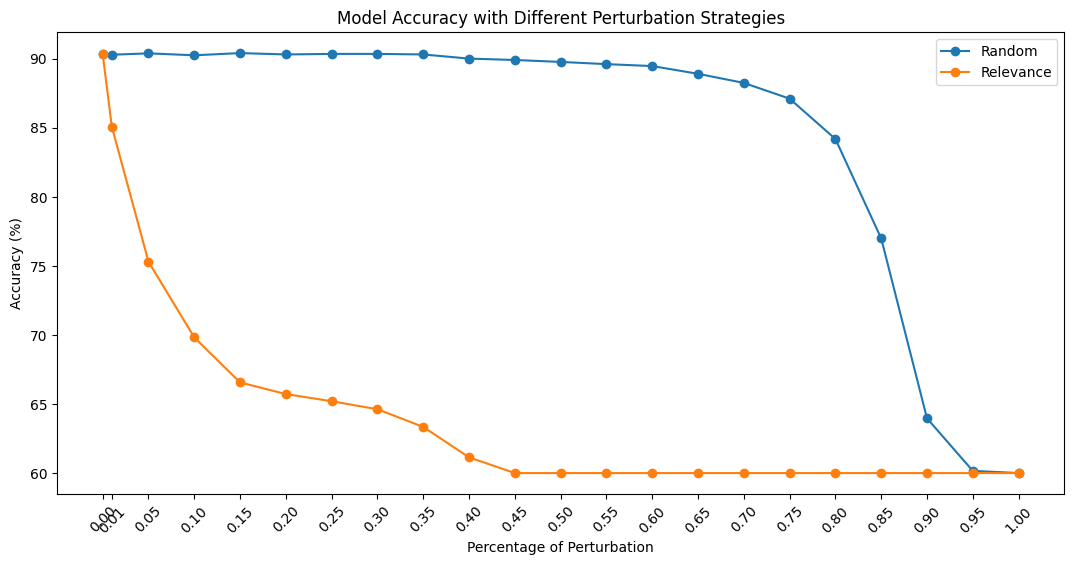

In [63]:
plt.figure(figsize=(13, 6))
for strategy, acc in accuracies.items():
    plt.plot([0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0], acc, '-o', label=strategy.capitalize())

plt.title('Model Accuracy with Different Perturbation Strategies')
plt.xlabel('Percentage of Perturbation')
plt.xticks(rotation=45)
plt.ylabel('Accuracy (%)')
plt.xticks(fractions)
plt.legend()
plt.show()

In [48]:
accuracies['relevance'] = [90.32,
 85.06,
 75.3,
 69.82,
 66.56,
 65.72,
 65.2,
 64.62,
 63.34,
 61.14,
 60.0,
 60.0,
 60.0,
 60.0,
60.0,
 60.0,
 60.0,
 60.0,
60.0,
 60.0,
 60.0,
 60.0]

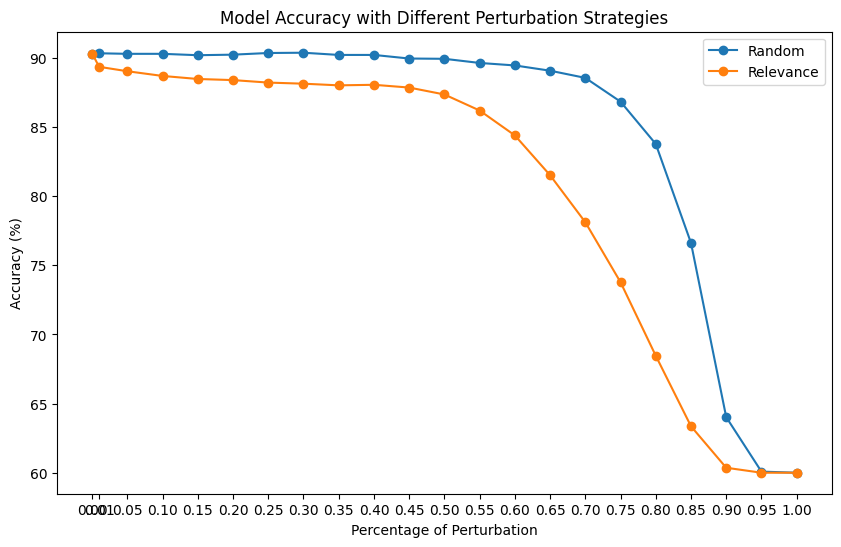

In [42]:
test_acc = accuracies.copy()
plt.figure(figsize=(10, 6))
for strategy, acc in test_acc.items():
    plt.plot([0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0], acc, '-o', label=strategy.capitalize())

plt.title('Model Accuracy with Different Perturbation Strategies')
plt.xlabel('Percentage of Perturbation')
plt.ylabel('Accuracy (%)')
plt.xticks(fractions)
plt.legend()
plt.show()

In [17]:
testMale,targetMale = test_dataset[0]
testFemale,targetFemale = test_dataset[50]

testMale,targetMale = testMale.unsqueeze(0).to(device),targetMale.unsqueeze(0).to(device)
testFemale,targetFemale = testFemale.unsqueeze(0).to(device),targetFemale.unsqueeze(0).to(device)

In [18]:
for layer in model.children():
    setattr(layer, "rule", Alpha1_Beta0_Rule())
    
lrp = LRP(model)

attributions_lrp_male = lrp.attribute(testMale, target=targetMale)
attributions_np_male = attributions_lrp_male.squeeze().cpu().detach().numpy()

for layer in model.children():
    setattr(layer, "rule", Alpha1_Beta0_Rule())
    
lrp = LRP(model)

attributions_lrp_female = lrp.attribute(testFemale, target=targetFemale)
attributions_np_female = attributions_lrp_female.squeeze().cpu().detach().numpy()

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [19]:
dataMale = testMale[0][0].cpu()
dataFemale = testFemale[0][0].cpu()
time = np.linspace(0, len(dataMale)/8000, len(dataMale))  

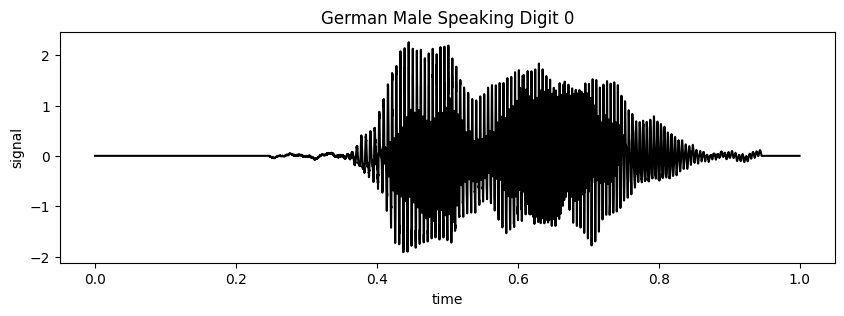

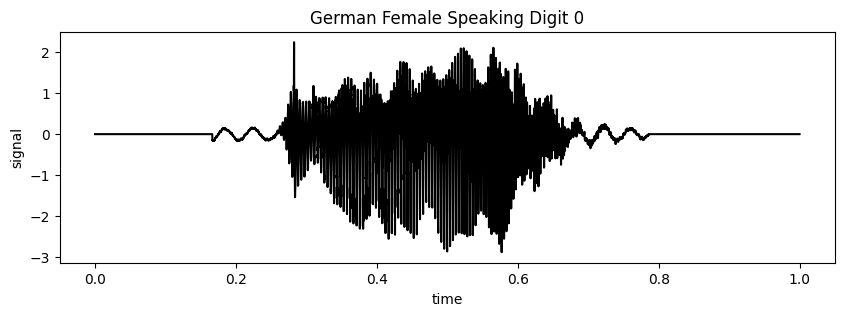

In [20]:
# Plot (a) - Waveform over time
plt.figure(figsize=(10, 3))
plt.plot(time, dataMale,color="k")
plt.xlabel('time')
plt.ylabel('signal')
plt.title('German Male Speaking Digit 0')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(time, dataFemale,color="k")
plt.xlabel('time')
plt.ylabel('signal')
plt.title('German Female Speaking Digit 0')
plt.show()

In [21]:
female_scaled = (attributions_np_female-attributions_np_female.mean())/(attributions_np_female.std())
male_scaled = (attributions_np_male-attributions_np_male.mean())/(attributions_np_male.std())

In [22]:
from IPython.display import Audio, display

In [36]:
display(Audio(data=dataMale, rate=8000, autoplay=True, embed=True))

In [23]:
display(Audio(data=dataMale, rate=8000))

In [24]:
display(Audio(data=male_scaled, rate=8000))

In [37]:
display(Audio(data=dataMale*np.maximum(attributions_np_male,0), rate=8000))

In [26]:
display(Audio(data=dataMale*attributions_np_male, rate=8000))

In [27]:
display(Audio(data=attributions_np_male, rate=8000))

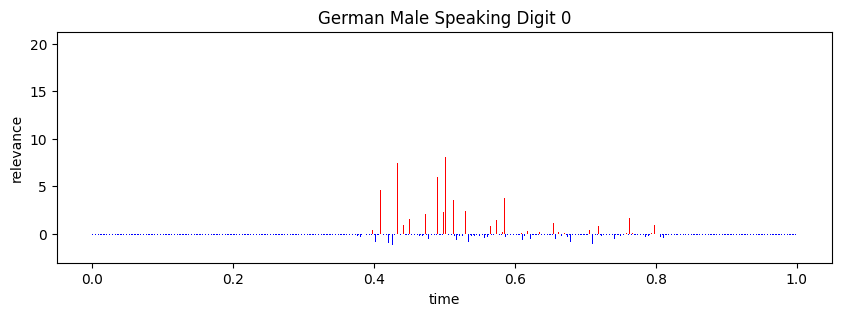

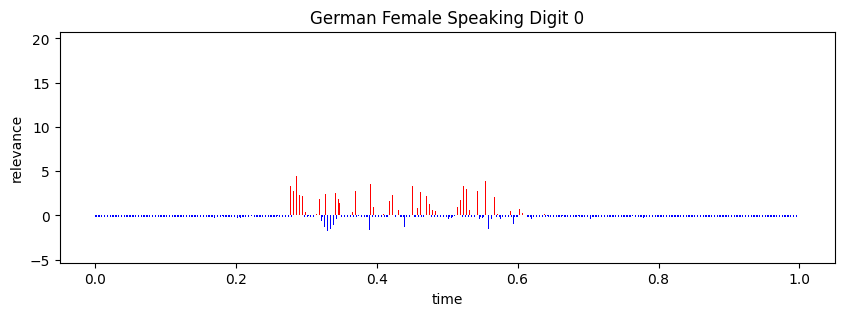

In [28]:
# Plot (b) - Relevance scores

positive_male = np.maximum(0, male_scaled)  # Positive relevance scores
negative_male = np.minimum(0, male_scaled)  # Negative relevance scores

plt.figure(figsize=(10, 3))
plt.bar(time, positive_male, width=1.0/(2*len(time)), color='red')
plt.bar(time, negative_male, width=1.0/(2*len(time)), color='blue')
plt.xlabel('time')
plt.ylabel('relevance')
plt.title('German Male Speaking Digit 0')
plt.show()


positive_female = np.maximum(0, female_scaled)  # Positive relevance scores
negative_female = np.minimum(0, female_scaled)  # Negative relevance scores

plt.figure(figsize=(10, 3))
plt.bar(time, positive_female, width=1.0/(2*len(time)), color='red')
plt.bar(time, negative_female, width=1.0/(2*len(time)), color='blue')
plt.xlabel('time')
plt.ylabel('relevance')
plt.title('German Female Speaking Digit 0')
plt.show()

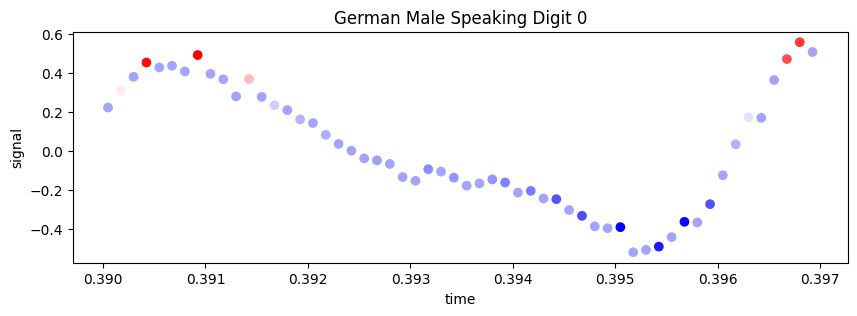

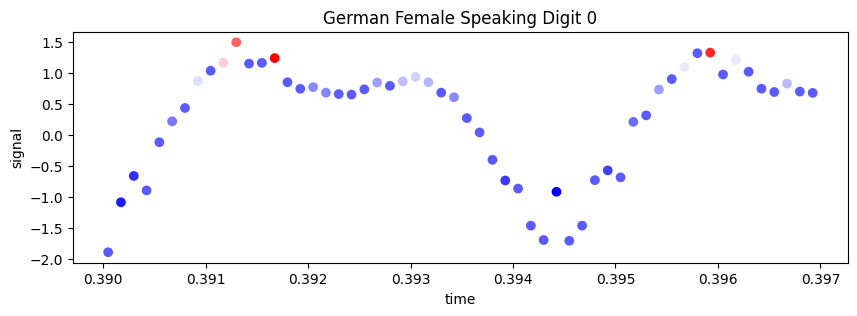

In [29]:
# Plot (c) - Zoomed-in waveform with color-coded relevance
# Select a range to zoom in on
start_time = 0.390  # Start of the zoomed-in time range
end_time = 0.397  # End of the zoomed-in time range
mask = (time >= start_time) & (time <= end_time)

plt.figure(figsize=(10, 3))
plt.scatter(time[mask], dataMale[mask], c=male_scaled[mask], cmap='bwr')
plt.xlabel('time')
plt.ylabel('signal')
plt.title('German Male Speaking Digit 0')
plt.show()

start_time = 0.390  # Start of the zoomed-in time range
end_time = 0.397  # End of the zoomed-in time range
mask = (time >= start_time) & (time <= end_time)

plt.figure(figsize=(10, 3))
plt.scatter(time[mask], dataFemale[mask], c=female_scaled[mask], cmap='bwr')
plt.xlabel('time')
plt.ylabel('signal')
plt.title('German Female Speaking Digit 0')
plt.show()

/tmp/ipykernel_35/601742566.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Relevance')


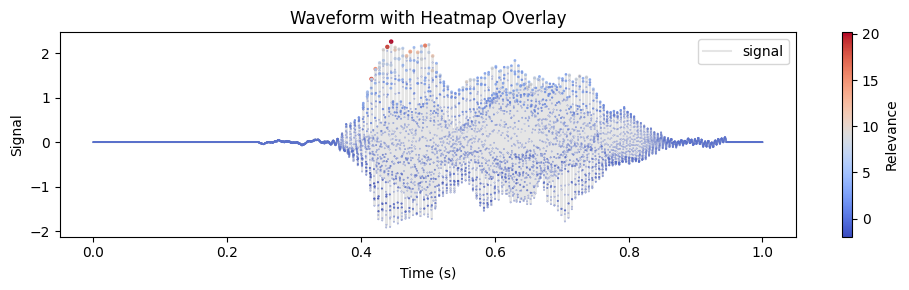

In [30]:
from matplotlib.cm import coolwarm

plt.figure(figsize=(10, 3))
plt.plot(time, dataMale, label='signal', color='grey',alpha=0.2)

# Create a scatter plot where the color intensity is based on relevance
# We'll use the 'coolwarm' colormap: cool (blue) colors will represent negative relevance, warm (red) colors for positive relevance
colors = coolwarm((male_scaled - min(male_scaled)) / (max(male_scaled) - min(male_scaled)))

# We use the relevance score's absolute value for the size of the scatter plot points
plt.scatter(time, dataMale, color=colors, s=abs(male_scaled)*0.25)

# Optional: colorbar to show the mapping from relevance score to color
sm = plt.cm.ScalarMappable(cmap=coolwarm, norm=plt.Normalize(vmin=min(male_scaled), vmax=max(male_scaled)))
plt.colorbar(sm, label='Relevance')

plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Waveform with Heatmap Overlay')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/3690082957.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Relevance')


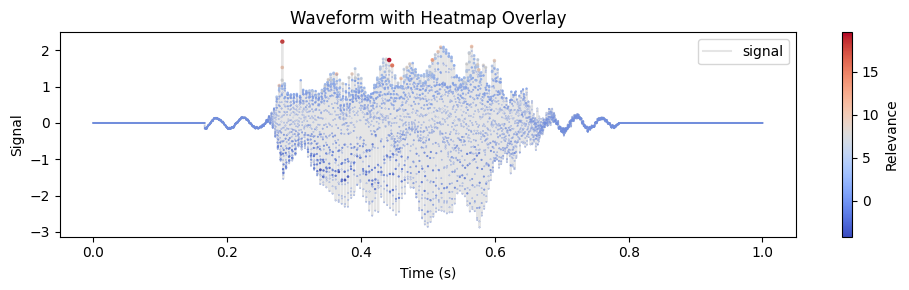

In [31]:
plt.figure(figsize=(10, 3))
plt.plot(time, dataFemale, label='signal', color='grey',alpha=0.2)

# Create a scatter plot where the color intensity is based on relevance
# We'll use the 'coolwarm' colormap: cool (blue) colors will represent negative relevance, warm (red) colors for positive relevance
colors = coolwarm((female_scaled - min(female_scaled)) / (max(female_scaled) - min(female_scaled)))

# We use the relevance score's absolute value for the size of the scatter plot points
plt.scatter(time, dataFemale, color=colors, s=abs(female_scaled)*0.25)

# Optional: colorbar to show the mapping from relevance score to color
sm = plt.cm.ScalarMappable(cmap=coolwarm, norm=plt.Normalize(vmin=min(female_scaled), vmax=max(female_scaled)))
plt.colorbar(sm, label='Relevance')

plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Waveform with Heatmap Overlay')
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
print(targetFemale)
output = model(testFemale.clone().detach().to(device))
_, predicted = torch.max(output.data, 1)
print(predicted)

tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
